In [1]:
# mounts Google Drive to the Colab VM
from google.colab import drive
drive.mount('/content/drive')

# scripts project foldername
FOLDERNAME = '/content/drive/My Drive/CS231N/Project/RainfallNowcasting/Radar/scripts'

# load python files from foldername
import sys
sys.path.append(FOLDERNAME)

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
#
from data_lab import *
from utils import *
from models import *
from metrics import *
from plot_tools import *
#
!sudo apt-get install libeccodes0
!pip install cfgrib netcdf4

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libeccodes-data
The following NEW packages will be installed:
  libeccodes-data libeccodes0
0 upgraded, 2 newly installed, 0 to remove and 32 not upgraded.
Need to get 2,861 kB of archives.
After this operation, 66.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libeccodes-data all 2.6.0-2 [1,260 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libeccodes0 amd64 2.6.0-2 [1,601 kB]
Fetched 2,861 kB in 2s (1,834 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tt

In [0]:
#########################################################################################
#################################### GLOBAL FEATURES ####################################
#########################################################################################
data_dir = '/content/drive/My Drive/CS231N/Project/RainfallNowcasting/Radar/MeteoNet/'
zone = "NW"                           # NW, SE
years = [2017]                        # 2016, 2017, 2018
months = [8]                          # 1...12
parts_month = [3]                     # 1,2,3 (each month is divided in 3 parts)
new_size = [64,64]                    # None = keep initial size
input_timeframes = 10                 # how many timeframes for input
output_timeframes = 5                 # how many timeframes for output
overlapping_data = 0                  # data overlap in time (= 1) or not (= 0)
archi = 'ddnet'                       # ddnet or convdlrm
fraction_test = 0.1                   # fraction of test data
rainfall_threshold_value = 80         # Value above which values are considered to be one
#########################################################################################
################################## ADDITIONAL FEATURES ##################################
#########################################################################################
features_bool = {'reflectivity': 1, 
                 'rainfall quality': 1,
                 'land sea': 1, 
                 'elevation': 1}
features_max_threshold = {'reflectivity': 60, 
                          'rainfall quality': 100, 
                          'land sea': 1, 
                          'elevation': 629}
features_min_threshold = {'reflectivity': 0, 
                          'rainfall quality': 0, 
                          'land sea': 0, 
                          'elevation': 0}
#
wf_model = None # None for no model, otherwise arpege or arome
weather_model_bool = {'temperature': 1, 
                      'dew point temperature' : 1,
                      'humidity': 1, 
                      'wind speed': 1, 
                      'wind directions': 1,
                      'wind components': 1, 
                      'pressure': 1,
                      'precipitation': 1}
weather_model_max_threshold = {'temperature': 313, 
                               'dew point temperature' : 313,
                               'humidity': 100, 
                               'wind speed': 35, 
                               'wind directions': 360,
                               'wind components': 35, 
                               'pressure': 105000,
                               'precipitation': rainfall_threshold_value}
weather_model_min_threshold = {'temperature': 263, 
                               'dew point temperature' : 263,
                               'humidity': 0, 
                               'wind speed': 0, 
                               'wind directions': 0,
                               'wind components': -35, 
                               'pressure': 96000,
                               'precipitation': 0}
#########################################################################################
#########################################################################################
#########################################################################################

In [5]:
# Getting data and features 
X, y, features_list = get_data_and_features(data_dir, zone, years, months, parts_month, 
                                            new_size, input_timeframes, output_timeframes,
                                            fraction_test, rainfall_threshold_value, 
                                            features_bool, weather_model_bool, wf_model,
                                            weather_model_max_threshold, weather_model_min_threshold,
                                            features_max_threshold, features_min_threshold,
                                            overlapping_data)
print(X.shape)
print(y.shape)
print(features_list)

Year: 2017 Month: 8 Part of the month: 3, Done !
Got rainfall
Year: 2017 Month: 8 Part of the month: 3, Done !
Got reflectivity
Year: 2017 Month: 8 Part of the month: 3, Done !
Got rainfall quality
Got land sea
Got elevation
(211, 10, 64, 64, 5)
(211, 5, 64, 64, 1)
['reflectivity', 'quality', 'land sea mask', 'elevation']


In [6]:
# Get train-test
X, y, X_test, y_test = split_train_test(fraction_test, X, y)
print(X.shape)
print(y.shape)
print(X_test.shape)
print(y_test.shape)
if archi=='ddnet':
  X_content = get_content_data(X)
  X_content_test = get_content_data(X_test)
  print(X_content.shape)
  print(X_content_test.shape)
N, T, H, W, C = X.shape

(190, 10, 64, 64, 5)
(190, 5, 64, 64, 1)
(21, 10, 64, 64, 5)
(21, 5, 64, 64, 1)
(190, 64, 64, 5)
(21, 64, 64, 5)


In [0]:
#
# Archi Parameters
#
loss = 'logcosh'
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
nk = 128
ks = 5
lks = 3
if archi=='convdlrm':
  activ = 'selu'
  init = 'lecun_normal'
  model = convdlrm_init(H, W, C, output_timeframes, nk, ks, lks, activ, init)
elif archi=='ddnet':
  activ = 'relu'
  init = 'he_normal'
  model = ddnet_init(H, W, C, output_timeframes, nk, ks, lks, activ, init)
#
bs = 2
ep = 1

In [10]:
# Build optimizer
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['acc', ssim, psnr, cor,
                       tf.keras.metrics.Precision(name='prec'),
                       tf.keras.metrics.Recall(name='recall')])

if archi=='convdlrm':
  # Fit the model
  history = model.fit(X, y, 
                      batch_size=bs, 
                      epochs=ep,
                      validation_split=0.1)
  # Get results on test set
  results = model.evaluate(X_test, y_test, batch_size=bs, return_dict=True)
elif archi=='ddnet':
  # Fit the model
  history = model.fit([X, X_content], y, 
                      batch_size=bs, 
                      epochs=ep,
                      validation_split=0.1)
  # Get results on test set
  results = model.evaluate([X_test, X_content_test], y_test, batch_size=bs, return_dict=True)

11/11 [==============================] - 2s 173ms/step - loss: 0.0378 - acc: 0.8683 - ssim: 0.7900 - psnr: 10.5123 - cor: 0.0610 - prec: 0.0000e+00 - recall: 0.0000e+00


/content/drive/My Drive/Results_project/ already exists


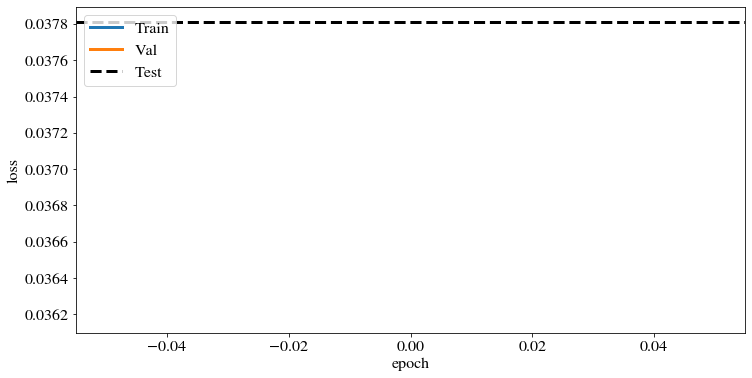

<Figure size 432x288 with 0 Axes>

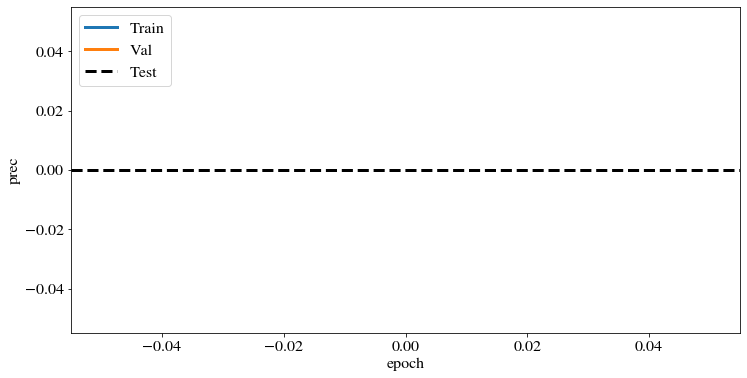

<Figure size 432x288 with 0 Axes>

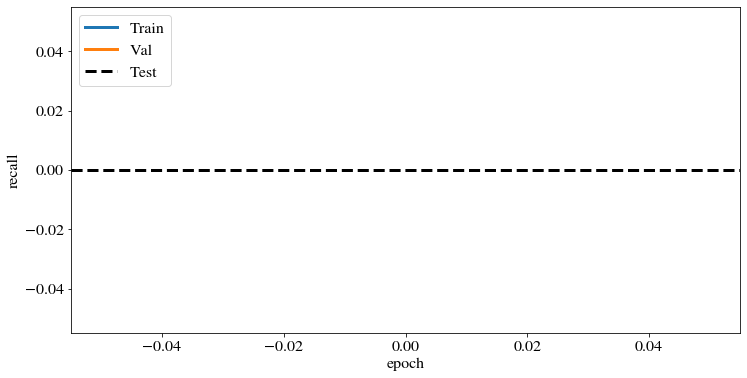

<Figure size 432x288 with 0 Axes>

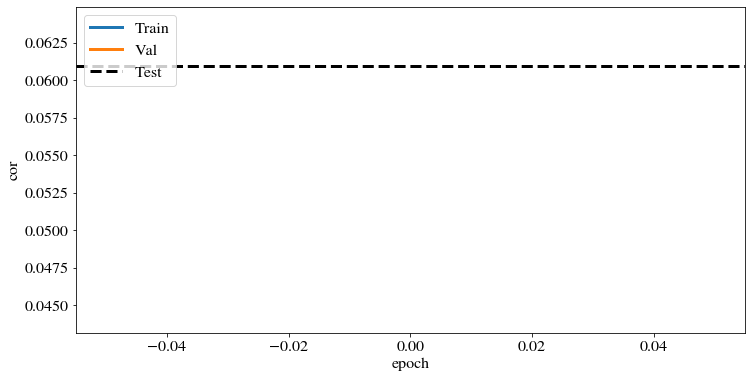

<Figure size 432x288 with 0 Axes>

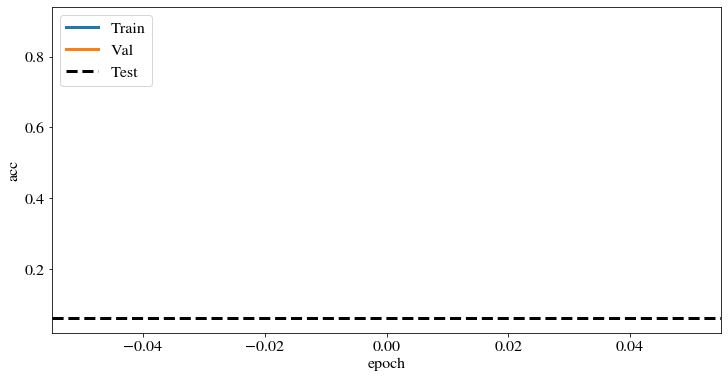

<Figure size 432x288 with 0 Axes>

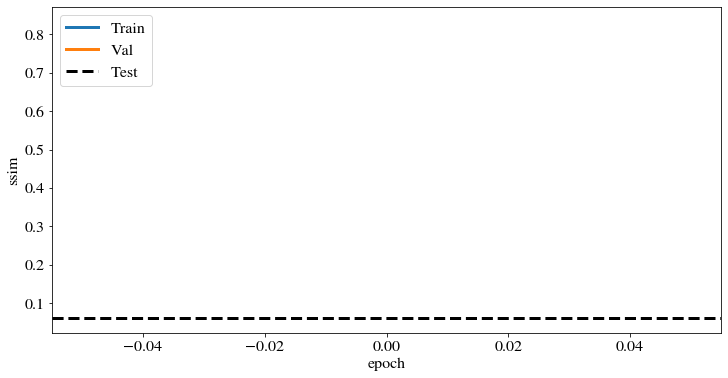

<Figure size 432x288 with 0 Axes>

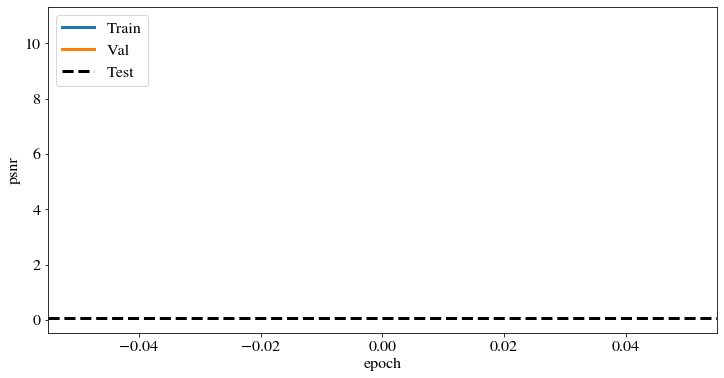

<Figure size 432x288 with 0 Axes>

In [16]:
# Plot of loss, accuracy, cor, prec and recall
foldername = "/content/drive/My Drive/Results_project/"
plot_history(history, results, save=True, foldername=foldername)

/content/drive/My Drive/Results_project/ already exists


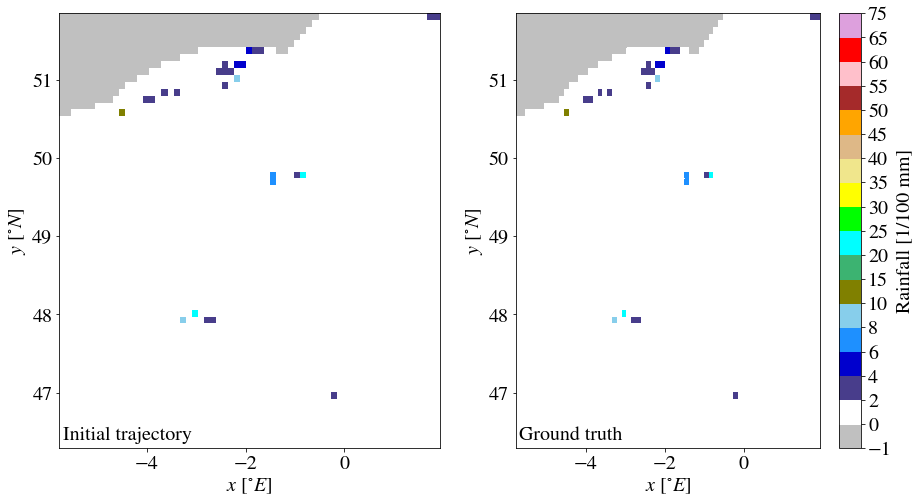

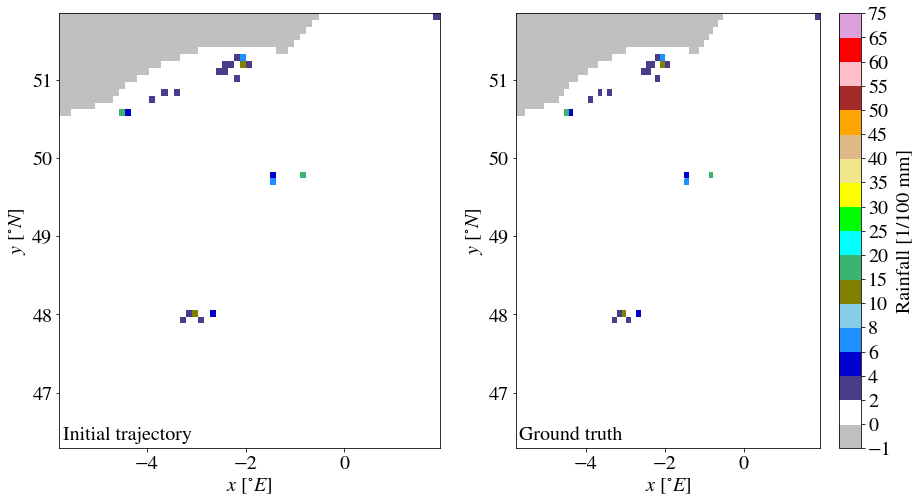

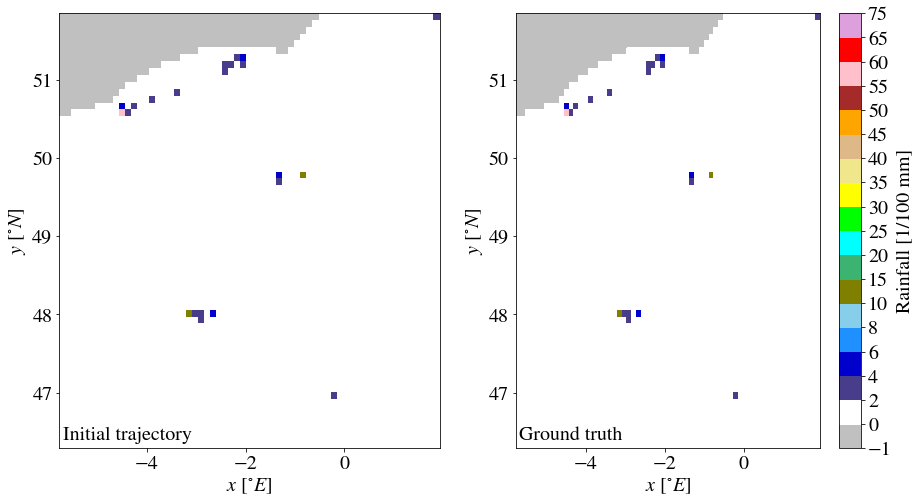

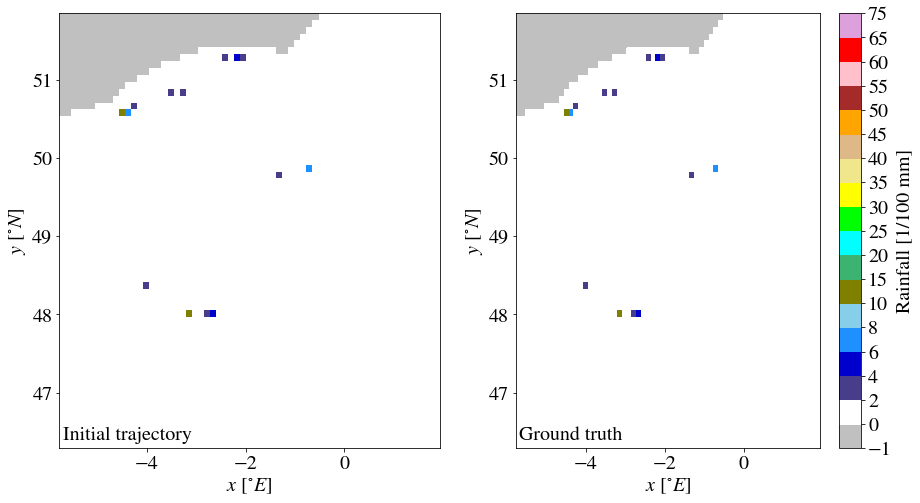

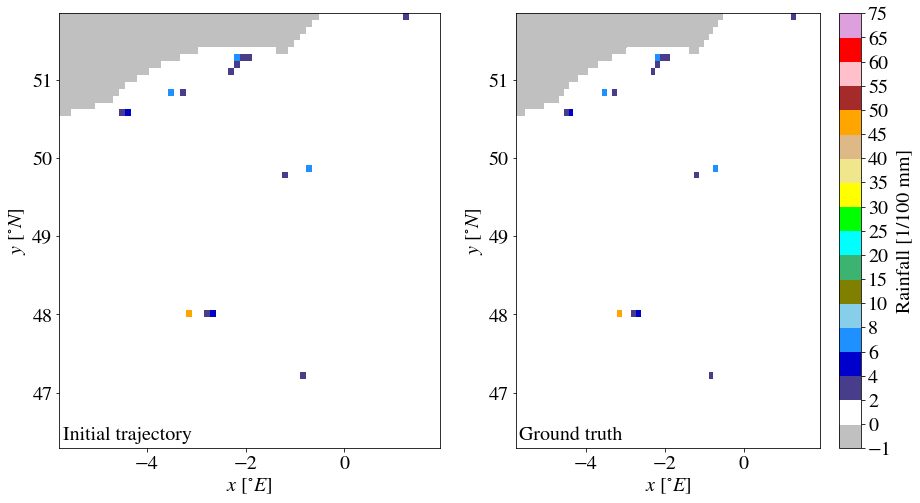

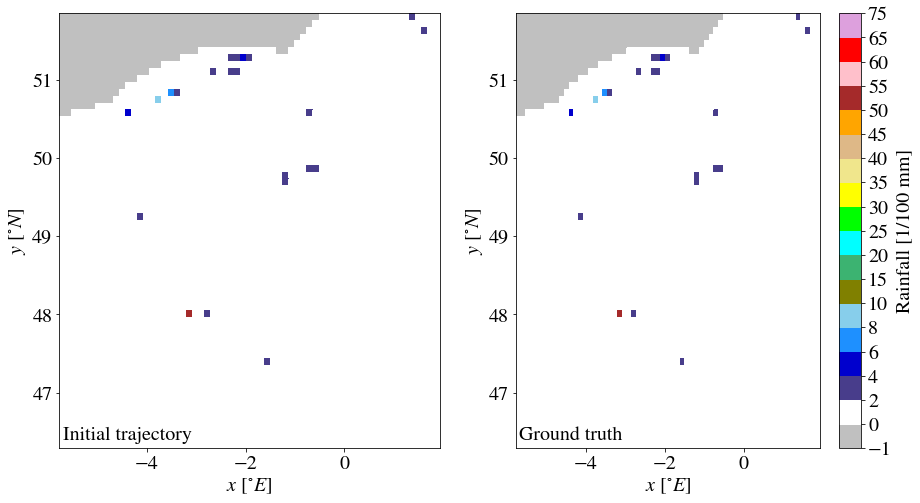

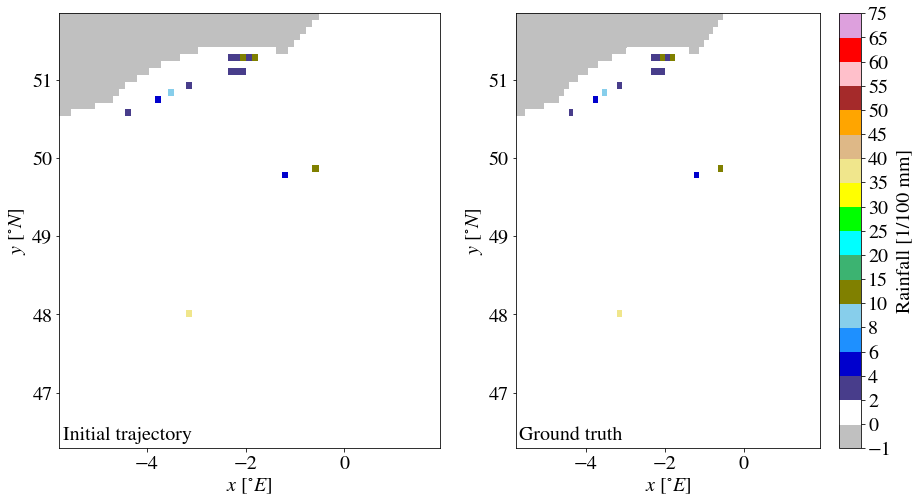

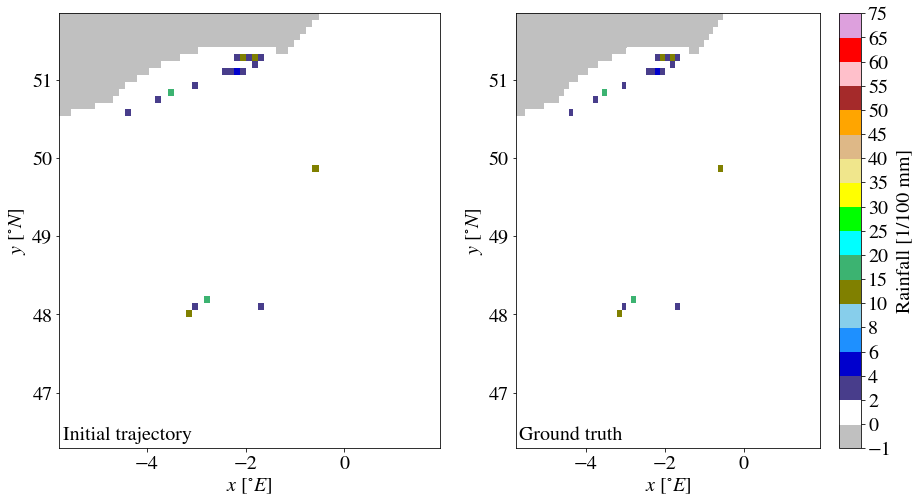

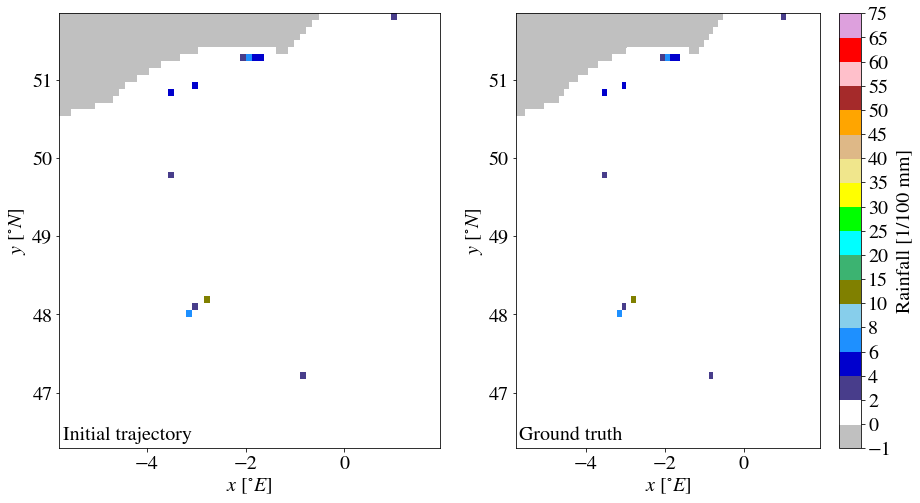

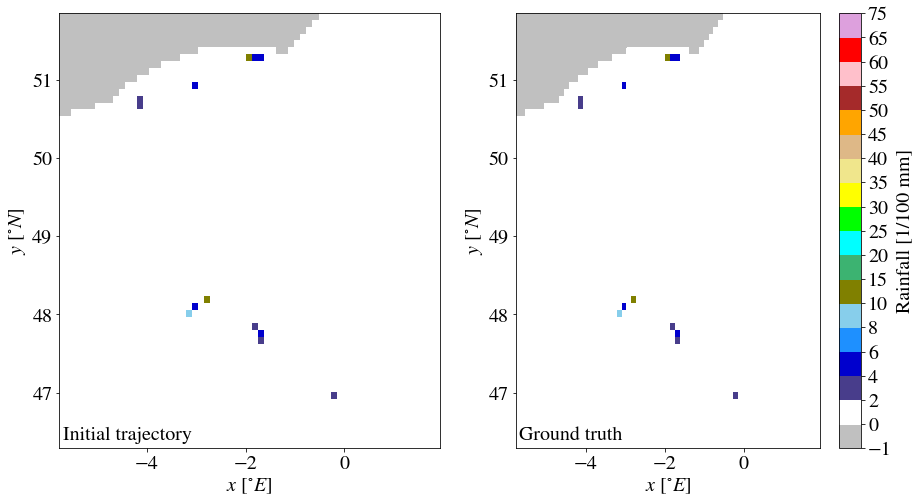

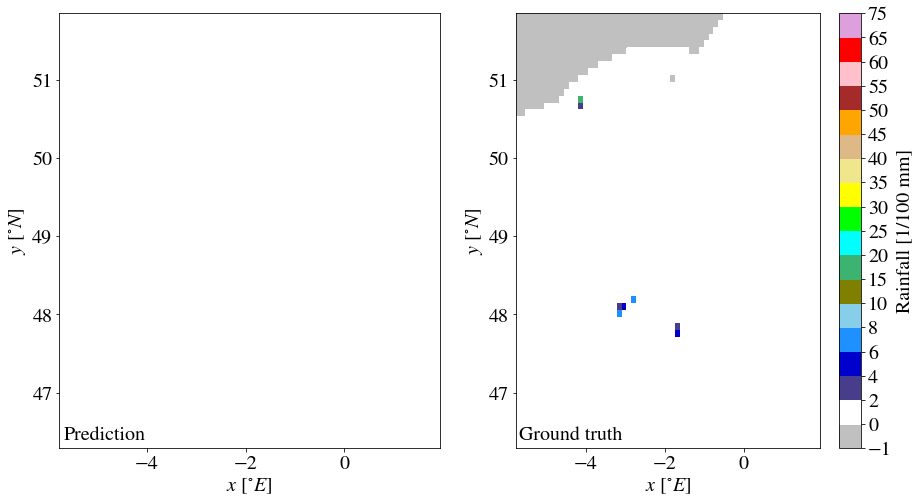

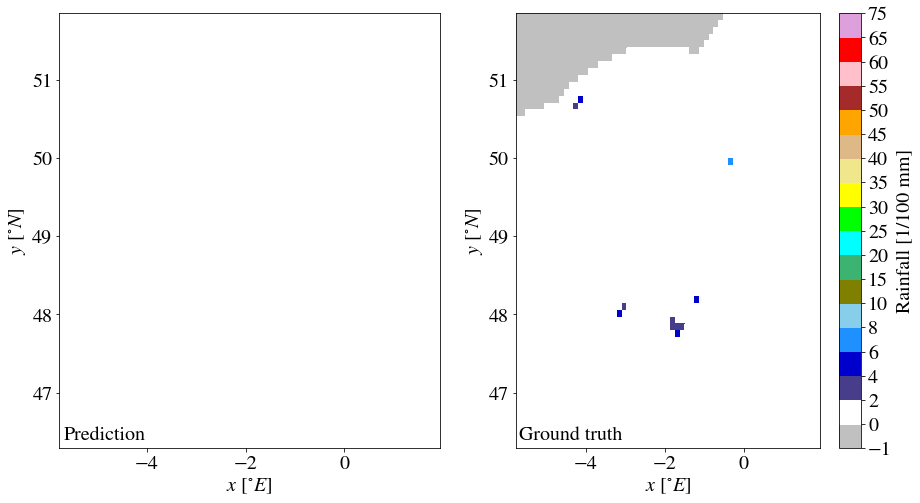

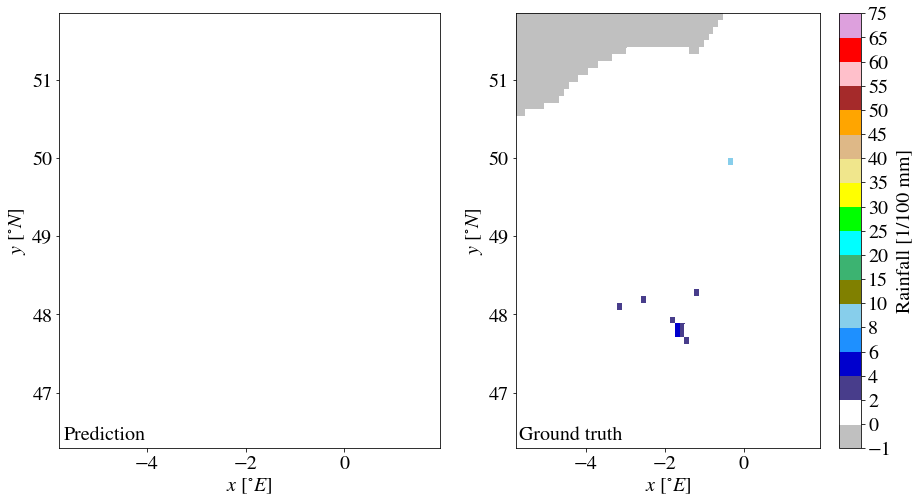

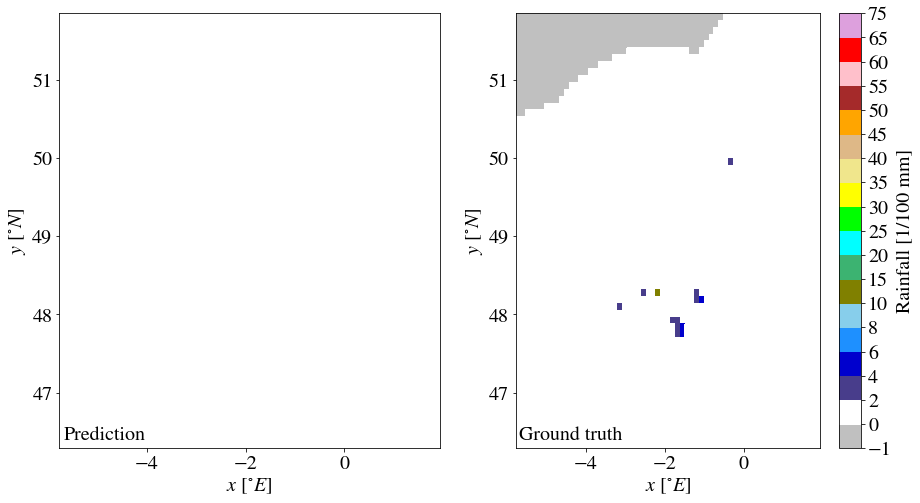

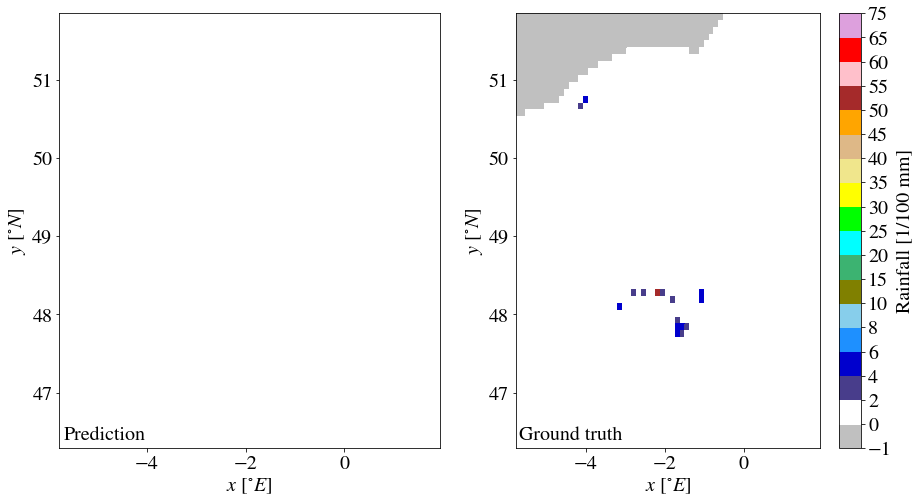

In [53]:
# Plot Train
itest = 1
track = tf.expand_dims(X[itest,:,:,:,0], axis=-1)
true_track = np.concatenate((track, y[itest]), axis=0)
if archi == 'convdlrm':
  track = np.concatenate((track[None,:,:,:,:], model.predict(track[None,:,:,:,:])), axis=1)
elif archi == 'ddnet':
  track_m = X[itest]
  track_c = X_content[itest]
  track = np.concatenate((track[None,:,:,:,:], model.predict([track_m[None,:,:,:,:], track_c[None,:,:,:]])), axis=1)
lat, lon = get_coords(data_dir, zone)
plot_track(true_track, track, rainfall_threshold_value, 
           new_size, input_timeframes, output_timeframes, 
           lat, lon, tag='train', save=True, foldername=foldername)